# Getting Started with Chromobius

1. [What is Chromobius?](#what-is-chromobius)
2. [Installing Chromobius](#installing)
3. [Creating a Color Code Circuit](#circuit)
4. [Decoding shots from your circuit with Chromobius](#decode)
5. [Using Sinter to collect and plot statistics](#sinter)

# Prereqs
This tutorial assumes you can read and write Python code, and that you have a working **Python 3.9**+ environment (perhaps you are reading this notebook in such an environment).

This tutorial assumes you are a somewhat familiar with quantum error correction, especially stabilizer codes, and *especially* the color code. It assumes that you already know what a color code is and why you would want to decode it.

<a class="anchor" id="what-is-chromobius"></a>
# What is Chromobius?

Chromobius is an [open source](https://github.com/quantumlib/chromobius) color code decoder.
Chromobius is an implementation of the [mobius decoder](https://arxiv.org/abs/2108.11395), which approximates the color code decoding problem as a minimum weight matching problem.
Chromobius uses [PyMatching](https://arxiv.org/abs/2303.15933) to solve the minimum weight matching problem.

<a class="anchor" id="installing"></a>
# Installing Chromobius

Chromobius is available as a python pypi package.
You can install Chromobius with `pip` by running the command `pip install chromobius`.

In [1]:
#!pip install chromobius~=1.0.0

You can check that you installed Chromobius by importing it and printing its version:

In [2]:
import chromobius
print(chromobius.__version__)

0.0.dev0


<a class="anchor" id="circuit"></a>
# Creating a Color Code Circuit

The hardest part of benchmarking a QEC circuit is creating the circuit in the first place.
For this notebook, you'll create a color code circuit with a phenomenological noise model.

A useful step when writing a QEC circuit is to first create a representation of the code that you can then use when generating the circuit.
Deal with spatial complexity before dealing with time dynamics.
In the case of the color code, the spatial complexity is in the tiling.
You want a hexagonal tiling in the bulk, but at the boundaries you want trapezoids.
You don't want to be dealing with trapezoids-vs-hexagons logic when also dealing with noise logic.
So, the first thing you'll do is make a list of the tiles in a color code.

A tile will be a list of 2d points (represented by complex number) as well as a color.
The color isn't normally needed for the circuit, but later you'll need to provide color information to Chromobius for Chromobius to work.
Also, the colors are useful for drawing the tiles, to check that you got it right.

In [3]:
import dataclasses

@dataclasses.dataclass
class Tile:
    qubits: list[complex]
    color: str

You can make the tiling for a color code by generating a hexagonal tiling, and truncating it to be inside three lines defining the boundaries.

To avoid issues with floating point rounding error, you don't want to use a perfect hexagonal grid.
You can distort the hexagons so that all their vertices have integer coordinates by changing the slopes of diagonal lines from 60 degrees to 45 degrees.

In [4]:
def make_color_code_tiles(*, base_data_width: int) -> list[Tile]:
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:
        # Check that it's within the intersection of the three boundary half planes.
        if q.imag < 0:
            # Too far up.
            return False
        if q.imag * 2 > q.real * 3:
            # Too far downleft.
            return False
        if q.imag * 2 > (w - q.real) * 3:
            # Too far downright.
            return False
        return True

    # Make a hexagonal tiling, cutting away any vertices that are out of bounds.
    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y
            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )
            # Only keep the hexagons and trapezoids.
            # No empty tiles, or single-point tiles, or etc.
            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles    

To check that the tiling is correct, you want to draw it.
The easiest way to do this is with an SVG image.
An SVG image is easy to show in a python notebook, because any class with a `_repr_svg_` method will display as an image.
And an SVG image is reasonably easy to create, because it's just a list of drawing commands written in an HTML style.
For example, the command `<path d="M0,0 L10,0 L10,10 L0,10 L0,0" fill="red" stroke="black" />` will draw a red square with a black outline.

By turning each tile into a path command, you can transform tiles into shapes in an SVG image:

In [5]:
class ShowAsSvg:
    def __init__(self, svg: str):
        self.svg = svg
    def _repr_svg_(self) -> str:
        return self.svg

def draw_tiles_as_svg(tiles: list[Tile]) -> ShowAsSvg:
    # Size the SVG to fit the tiles.
    max_r = max(q.real for tile in tiles for q in tile.qubits)
    max_i = max(q.imag for tile in tiles for q in tile.qubits)
    svg = f'<svg width="{max_r * 20}" height="{max_i * 20}" xmlns="http://www.w3.org/2000/svg">\n'

    # Add each tile to the SVG as a filled shape.
    for tile in tiles:
        pts = [q * 20 for q in tile.qubits]
        p = pts[-1]
        d = f'M{p.real},{p.imag}'
        for p in pts:
            d += f' L{p.real},{p.imag}'
        svg += f'<path d="{d}" fill="{tile.color}" stroke="black" />\n'
    
    svg += '</svg>'
    
    return ShowAsSvg(svg)

And then you can use this method on your color code tiling method to get a picture of a color code!
It will look a bit wobbly because you distorted the vertices to land on integer coordinates, but that's fine:

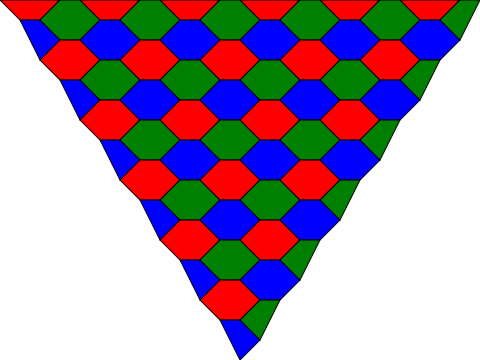

In [6]:
draw_tiles_as_svg(make_color_code_tiles(base_data_width=13))

Now that you have the building blocks of a color code, you can go about turning them into a circuit.
For a phenomenological noise model there two main tasks: measuring the stabilizers, and measuring the observables.
You first need to prepare the system by measuring the observables and stabilizers without noise.
Then you need to perform a specified number of rounds of stabilizer measurement with noise.
Finally, you need to turn the noise off and terminate the system with one last measurement of the stabilizers and the observables.

The stabilizer measurements need to declare detectors comparing them to the corresponding measurement from the previous round.
The easiest way to do this is to make sure you always measure the stabilizers in the same order, so that the offset between measurements to compare is always the same.
For the observable measurements, the measurement indexing logic is much easier because you can lean on the fact that stim's `OBSERVABLE_INCLUDE` instruction can gradually accumulate measurements for an observable over the entire circuit.
(The `DETECTOR` instruction instead requires all measurements to be given at once).

Other details you want to include are: `QUBIT_COORD` instructions indicating the spatial layout, `TICK` instructions indicating the progression of time, noise instructions indicating qubits to depolarize and measurements to probabilistically flip, and using a `REPEAT` block to compress the size of the circuit. For more complicated circuits you should try to split the circuit construction into more steps, for example adding noise could be done after making the rest of the circuit so that it wasn't complicating the circuit creationg logic. But for a phenomenological circuit it's not *too* bad.

A very key detail that you must include in this circuit, that wouldn't be normally included in a stim circuit, is annotations on every detector stating its basis and color for Chromobius.
You do this by giving the detector coordinate data.
The 4th coordinate of the coordinate data says the basis and the color, with 0 meaning red X, 1 meaning green X, 2 meaning blue X, 3 meaning red Z, 4 meaning green Z, and 5 meaning blue Z.

As you can perhaps tell, making a circuit can be a very involved process!
This notebook isn't really about making circuits, and you probably don't want to get too bogged down in this detail, so maybe you should just bite down and write a function that makes a color code circuit:

In [7]:
import stim
from typing import Literal

def make_color_code_circuit(
    *,
    obs_basis: Literal['X', 'Y', 'Z'],
    base_data_width: int,
    rounds: int,
    noise_strength: float,
) -> stim.Circuit:
    """Creates a color code circuit with a phenomenological noise model.

    The circuit's detectors are annotated so that Chromobius can decode them.

    Args:
        obs_basis: The basis of the observable to prepare and verify at the end of the circuit.
        base_data_width: The number of data qubits along one side of the patch.
        rounds: The number of times to apply depolarizing noise. One more than the number of
            times to apply measurement noise.
        noise_strength: The strength of the depolarizing noise applied to the data qubits,
            and also the probability of noisy measurements reporting the wrong result.

    Returns:
        The created circuit.
    """

    def mpp_targets(qubits: list[complex], basis: Literal['X', 'Y', 'Z']) -> list[stim.GateTarget]:
        target_b = {'X': stim.target_x, 'Y': stim.target_y, 'Z': stim.target_z}[basis]
        indices = sorted(q2i[q] for q in qubits)
        targets = []
        for k in indices:
            targets.append(target_b(k))
            targets.append(stim.target_combiner())
        targets.pop()
        return targets

    def measure_observables() -> stim.Circuit:
        c = stim.Circuit()
        c.append("MPP", mpp_targets(sorted_qubits, obs_basis))
        c.append("OBSERVABLE_INCLUDE", stim.target_rec(-1), 0)
        return c
        
    def measure_stabilizers(*, data_noise_after: bool, measure_noise: bool, include_detectors: bool) -> stim.Circuit:
        c = stim.Circuit()

        # Measure every stabilizer.
        for basis in ['X', 'Z']:
            for tile in tiles:
                c.append("MPP", mpp_targets(tile.qubits, basis), noise_strength if measure_noise else None)
        
        # Compare the measurements to the previous round to produce detection events.
        if include_detectors:
            num_stabilizers = len(tiles) * 2
            for xz in range(2):
                for k, tile in enumerate(tiles):
                    center = sum(tile.qubits) / len(tile.qubits)
                    chromobius_color = {'red': 0, 'green': 1, 'blue': 2}[tile.color]
                    chromobius_annotation = chromobius_color + xz*3
                    offset = xz * len(tiles) + k
                    c.append("DETECTOR", [
                        stim.target_rec(-num_stabilizers + offset), 
                        stim.target_rec(-num_stabilizers*2 + offset),
                    ], [center.real, center.imag, 0, chromobius_annotation])

        # End the round.
        if data_noise_after:
            c.append("DEPOLARIZE1", range(len(all_qubits)), noise_strength)
        c.append("SHIFT_COORDS", [], [0, 0, 1])
        c.append("TICK")

        return c

    tiles = make_color_code_tiles(base_data_width=base_data_width)
    circuit = stim.Circuit()

    # Index the qubit coordinates and put coordinate data in the circuit.
    all_qubits = {q for tile in tiles for q in tile.qubits}
    sorted_qubits = sorted(all_qubits, key=lambda q: (q.real, q.imag))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}
    for q, i in q2i.items():
        circuit.append("QUBIT_COORDS", [i], [q.real, q.imag])

    # Use the helper methods you just defined to build the rounds and combine them into a full circuit.
    circuit += measure_observables()
    circuit += measure_stabilizers(data_noise_after=True, measure_noise=False, include_detectors=False)
    circuit += (rounds - 1) * measure_stabilizers(data_noise_after=True, measure_noise=True, include_detectors=True)
    circuit += measure_stabilizers(data_noise_after=False, measure_noise=False, include_detectors=True)
    circuit += measure_observables()
    
    return circuit

To look at the circuit, you can make a timeline diagram:

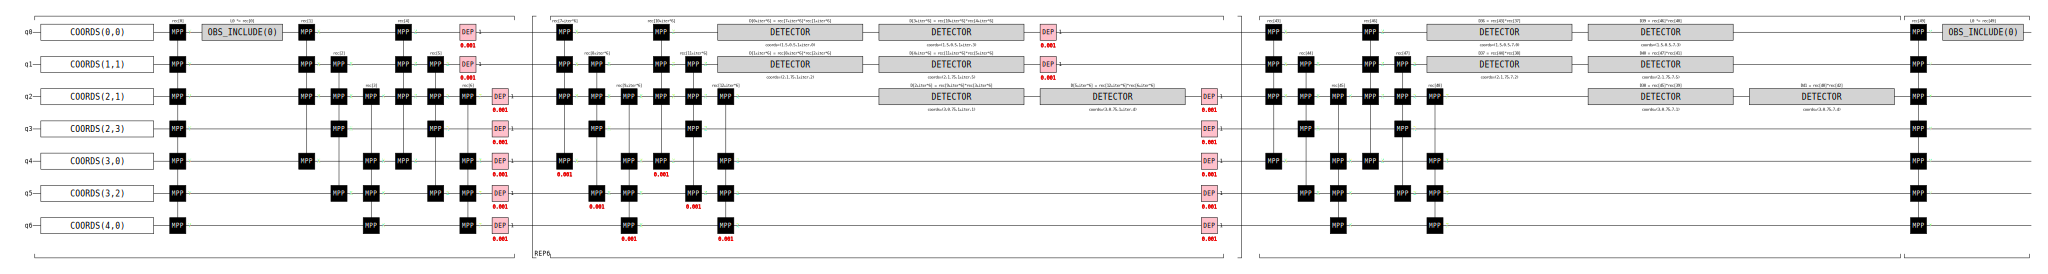

In [8]:
make_color_code_circuit(
    obs_basis='Y',
    base_data_width=3,
    rounds=7,
    noise_strength=1e-3,
).diagram("timeline")

You can also make a "detslice" diagram, which shows stabilizers of the circuit from moment to moment.
It's called "det" slice because the stabilizers that are shown correspond to the sensitivity regions of the detectors declared by the circuit.
For a color code, this means the detslice diagram looks like a color code but with all the shapes the same color since the color in the detslice diagram is about stabilizer basis:

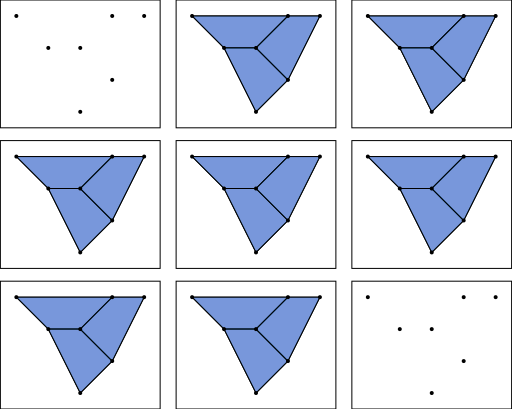

In [9]:
make_color_code_circuit(
    obs_basis='Y',
    base_data_width=3,
    rounds=7,
    noise_strength=1e-3,
).diagram("detslice")

<a class="anchor" id="decode"></a>
# Decoding shots from your circuit with Chromobius

To decode shots with Chromobius, you first need a circuit to take shots from:

In [10]:
circuit = make_color_code_circuit(
    obs_basis='X',
    base_data_width=7,
    rounds=5,
    noise_strength=1e-2,
)
sampler = circuit.compile_detector_sampler()

To configure Chromobius, you need the detector error model (the "dem") of the circuit.
A dem is basically a Tanner graph directly describing all the error mechanisms and their symptoms, abstracting away all of the circuit details that a decoder doesn't want to have to care about.

You can get the circuit's dem with `circuit.detector_error_model()`.
You can make diagrams of dems using their diagram method.
For example, the `matchgraph-svg` diagram type makes a 2d image of the decoding graph.
Each node in the diagram is a detector, and each edge is an error.
The color code decoding graph is interesting in that it has hyper edges; errors with three symptoms instead of one or two.
In the diagram these are shown by blue lines converging to a common midpoint from all three symptoms.
Also, since the circuit has multiple rounds, the dem has multiple layers.

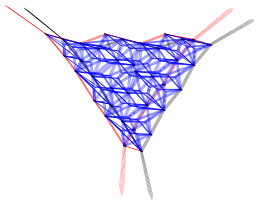

In [11]:
dem = circuit.detector_error_model()
dem.diagram("matchgraph-svg")

You can also get a 3d model of the graph using the `matchgraph-3d` diagram type.
(If you're viewing this notebook on github, the 3d viewer won't show up.
If it does show up, you can click and drag to move the view around.)

In [12]:
dem.diagram("matchgraph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":468,"max":[46.0785331726074,34.6817970275879,19.4751358032227],"min":[0.0817275047302246,-3.8176417350769,-1.47513675689697],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":210,"max":[41.8868141174316,33.8922309875488,19.8790016174316],"min":[-3.65077877044678,-4.29351329803467,-1.87900161743164],"name":"buf_red_scattered_lines","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":2880,"max":[37.4444427490234,24.9166660308838,15],"min":[4.5,1.5,3],"name":"buf_blue_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":5616,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":2520,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962},{"buffer":3,"byteLength":34560,"byteOffset":0,"name":"buf_blue_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":5616,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,q6r6QAAAIEAAAEBAiKoGP0YnXcBAhKy+q6r6QAAAIEAAAEBAjuM4QVZV3UAAAEBAq6r6QAAAIEAAAEBAchxvQaqqikAAAEBAjuM4QVZV3UAAAEBAVlVdQQAAIEEAAEBAchxvQaqqikAAAEBAq6qeQQAAIEAAAEBAVlVdQQAAIEEAAEBAxnGMQaqqfkEAAEBAxnGMQaqqfkEAAEBAq6qeQQAAmEEAAEBAq6qeQQAAIEAAAEBAOY7XQaqqikAAAEBAq6qeQQAAmEEAAEBAxnG8QVVVx0EAAEBAxnG8QVVVx0EAAEBA2dvLQfyYBkJI0by/xnG8QVVVx0EAAEBAOY7LQauqrEEAAEBAOY7XQaqqikAAAEBAqqr+QQAAIEAAAEBAyHHgQVVVhUEAAEBAOY7LQauqrEEAAEBAyHHgQVVVhUEAAEBAOY77QVZVSUEAAEBAqqr+QQAAIEAAAEBAHMcVQlVVZUAAAEBA5DgIQlZV9UAAAEBAOY77QVZVSUEAAEBA5DgIQlZV9UAAAEBAHMcVQlVVZUAAAEBAHMcVQlVVZUAAAEBAJ7k2QlZanb8AAMe4AACQQAAAwD8AAEBAAACQQAAAwD8AAMBAOY4DQVVVvUAAAEBAOY4DQVVVvUAAAMBAHMc5QVZVVUAAAEBAHMc5QVZVVUAAAMBAAAAoQQAAEEEAAEBAAAAoQQAAEEEAAMBAOY5jQauqbkEAAEBAOY5jQauqbkEAAMBAAACEQQAAwD8AAEBAAACEQQAAwD8AAMBAHMeVQVZV1UAAAEBAHMeVQVZV1UAAAMBAjuOMQVZVRUEAAEBAjuOMQVZVRUEAAMBAAACEQQAAkEEAAEBAAACEQQAAkEEAAMBAHMehQVZVv0EAAEBAHMehQVZVv0EAAMBAjuO8QVZVVUAAAEBAjuO8QVZVVUAAAMBAAAC0QQAAEEEAAEBAAAC0QQAAEEEAAMBAHMfFQauqekEAAEBAHMfFQauqekEAAMBAjuOwQauqpEEAAEBAjuOwQauqpEEAAMBAAADkQQAAwD8AAEBAAADkQQAAwD8AAMBAHMf1QVZV1UAAAEBAHMf1QVZV1UAAAMBAjuPgQVZVOUEAAEBAjuPgQVZVOUEAAMBAx3EIQlVVJUAAAEBAx3EIQlVVJUAAAMBAq6r6QAAAIEAAAEBAq6r6QAAAIEAAAMBAjuM4QVZV3UAAAEBAjuM4QVZV3UAAAMBAchxvQaqqikAAAEBAchxvQaqqikAAAMBAVlVdQQAAIEEAAEBAVlVdQQAAIEEAAMBAxnGMQaqqfkEAAEBAxnGMQaqqfkEAAMBAq6qeQQAAIEAAAEBAq6qeQQAAIEAAAMBAxnGwQVZV9UAAAEBAxnGwQVZV9UAAAMBAOY6nQVZVVUEAAEBAOY6nQVZVVUEAAMBAq6qeQQAAmEEAAEBAq6qeQQAAmEEAAMBAxnG8QVVVx0EAAEBAxnG8QVVVx0EAAMBAOY7XQaqqikAAAEBAOY7XQaqqikAAAMBAqqrOQQAAIEEAAEBAqqrOQQAAIEEAAMBAyHHgQVVVhUEAAEBAyHHgQVVVhUEAAMBAOY7LQauqrEEAAEBAOY7LQauqrEEAAMBAqqr+QQAAIEAAAEBAqqr+QQAAIEAAAMBA5DgIQlZV9UAAAEBA5DgIQlZV9UAAAMBAOY77QVZVSUEAAEBAOY77QVZVSUEAAMBAHMcVQlVVZUAAAEBAHMcVQlVVZUAAAMBAq6r6QAAAIEAAAMBAoCtNPhokbsCyOohAq6r6QAAAIEAAAMBAjuM4QVZV3UAAAMBAq6r6QAAAIEAAAMBAchxvQaqqikAAAMBAjuM4QVZV3UAAAMBAVlVdQQAAIEEAAMBAchxvQaqqikAAAMBAq6qeQQAAIEAAAMBAVlVdQQAAIEEAAMBAxnGMQaqqfkEAAMBAxnGMQaqqfkEAAMBAq6qeQQAAmEEAAMBAq6qeQQAAIEAAAMBAOY7XQaqqikAAAMBAq6qeQQAAmEEAAMBAxnG8QVVVx0EAAMBAxnG8QVVVx0EAAMBAZirNQR+PCUKWp2RAxnG8QVVVx0EAAMBAOY7LQauqrEEAAMBAOY7XQaqqikAAAMBAqqr+QQAAIEAAAMBAyHHgQVVVhUEAAMBAOY7LQauqrEEAAMBAyHHgQVVVhUEAAMBAOY77QVZVSUEAAMBAqqr+QQAAIEAAAMBAHMcVQlVVZUAAAMBA5DgIQlZV9UAAAMBAOY77QVZVSUEAAMBA5DgIQlZV9UAAAMBAHMcVQlVVZUAAAMBAHMcVQlVVZUAAAMBAG

Anyways, putting the cool 3d model viewer aside, now that you have the dem you can use it to configure Chromobius.
You do this by calling `compile_decoder_for_dem`, like this:

In [13]:
decoder = chromobius.compile_decoder_for_dem(dem)

With the decoder in hand, you can take detector shots from the circuit and have Chromobius predict whether or not the logical observable was flipped.
The method for doing this is `predict_obs_flips_from_dets_bit_packed`.
The `bit_packed` means each byte of data given to it must contain 8 bits of data, instead of only 1 bit per byte.
You can get bit packed detection events from stim samplers by passing `bit_packed=True`.
Then you can count how many times Chromobius mispredicted whether observables were flipped:

In [14]:
import numpy as np
dets, actual_obs = sampler.sample(
    shots=1024,
    separate_observables=True,
    bit_packed=True,
)

predicted_obs = decoder.predict_obs_flips_from_dets_bit_packed(dets)

mistakes = np.count_nonzero(np.any(predicted_obs != actual_obs, axis=1))
print(f'{mistakes=}')

mistakes=0


1024 shots isn't really enough to get a good sense of the error rate for this circuit.
It's possible you didn't even see one mistake.
Try taking a hundred times as many shots:

In [15]:
import time

t0 = time.monotonic()
total_shots = 0
total_mistakes = 0
for _ in range(100):
    total_shots += 1024
    dets, actual_obs = sampler.sample(
        shots=1024,
        separate_observables=True,
        bit_packed=True,
    )
    predicted_obs = decoder.predict_obs_flips_from_dets_bit_packed(dets)
    total_mistakes += np.count_nonzero(np.any(predicted_obs != actual_obs, axis=1))
t1 = time.monotonic()

print(f'       shots = {total_shots}')
print(f'    mistakes = {total_mistakes}')
print(f'  error_rate = {total_mistakes / total_shots:%}')
print(f'shots/second = {round(total_shots / (t1 - t0))}')

       shots = 102400
    mistakes = 42
  error_rate = 0.041016%
shots/second = 73963


Nice! Pretty quick, right? But you probably don't want to have to deal with all this batching and collecting and timing stuff (nevermind multiprocessing!). That's what `sinter` is for.

<a class="anchor" id="sinter"></a>
# Using Sinter to collect and plot statistics

Sinter is a tool for performing bulk Monte Carlo sampling of quantum error correction circuits using python multiprocessing.
Like Chromobius, you can install `sinter` using `pip`:

In [16]:
!pip install sinter~=1.12.0 --quiet

To get sinter to sample and decoder a circuit, you need to wrap the circuit in a `sinter.Task` that provides metadata about the circuit.
This metadata will be useful later, when plotting.
Typically you want to explore a variety of circuit sizes and noise strength, so you should define a list of sinter tasks doing that:

In [17]:
import sinter

tasks = [
    sinter.Task(
        circuit=make_color_code_circuit(
            obs_basis=b,
            base_data_width=d,
            rounds=r,
            noise_strength=p,
        ),
        json_metadata={'d': d, 'p': p, 'r': r, 'b': b},
    )
    for d in [3, 5, 7, 9]
    for r in [d*4]
    for b in ['X']
    for p in [0.01, 0.02]
]

Once you have your tasks, you call `sinter.collect` on them to perform sampling.
You also need to specify how many shots to take from each task, how many errors need to be seen before sampling can stop early, how many worker processes to use, and what decoders to use.
You want to use chromobius, so you should set the decoders to `['chromobius']`.
Because chromobius isn't one of sinter's built in decoders, you also have to tell it what `'chomobius'` means.
You do that by giving a dictionary to the `custom_decoders` argument mapping strings to instances of `sinter.Decoder`.
For convenience, the `chromobius.sinter_decoders()` method returns this dictionary.

Collecting these stats should take less than a minute, but you can still specify `print_progress=True` to get progress updates.

In [18]:
import os

stats = sinter.collect(
    tasks=tasks,
    num_workers=os.cpu_count(),
    max_shots=100_000,
    max_errors=100,
    print_progress=True,
    decoders=['chromobius'],
    custom_decoders=chromobius.sinter_decoders(),
)

Starting 8 workers...
4 cases left:
    chromobius processes=5  ~core_mins_left=1       shots_left=97400    errors_left=94      {b=X,d=7,p=0.01,r=28}
    chromobius processes=3  ~core_mins_left=1       shots_left=99700    errors_left=88      {b=X,d=7,p=0.02,r=28}
    chromobius processes=0  ~core_mins_left=None    shots_left=100000   errors_left=100     {b=X,d=9,p=0.01,r=36}
    chromobius processes=0  ~core_mins_left=None    shots_left=100000   errors_left=100     {b=X,d=9,p=0.02,r=36}
3 cases left:
    chromobius processes=5  ~core_mins_left=1       shots_left=89200    errors_left=76      {b=X,d=7,p=0.01,r=28}
    chromobius processes=3  ~core_mins_left=4       shots_left=99900    errors_left=100     {b=X,d=9,p=0.01,r=36}
    chromobius processes=0  ~core_mins_left=1       shots_left=99900    errors_left=99      {b=X,d=9,p=0.02,r=36}
3 cases left:
    chromobius processes=2  ~core_mins_left=1       shots_left=69900    errors_left=35      {b=X,d=7,p=0.01,r=28}
    chromobius processes

Now you have statistics describing how often each circuit experienced a logical error, when decoded using Chromobius.
To plot these statistics, you can use `matplotlib`.
You can iterate over the list of stats yourself, but it's usually more convenient to use sinter's `sinter.plot_error_rate` helper method.
It will split the statistics into curves according to a grouping function you provide, lay out those curves over the X axis using an X function you provide, and set the Y coordinate to the error rate.
It will also give uncertainty highlights indicating hypotheses with likeihoods near the max likelihood hypothesis.

In [19]:
!pip install matplotlib --quiet

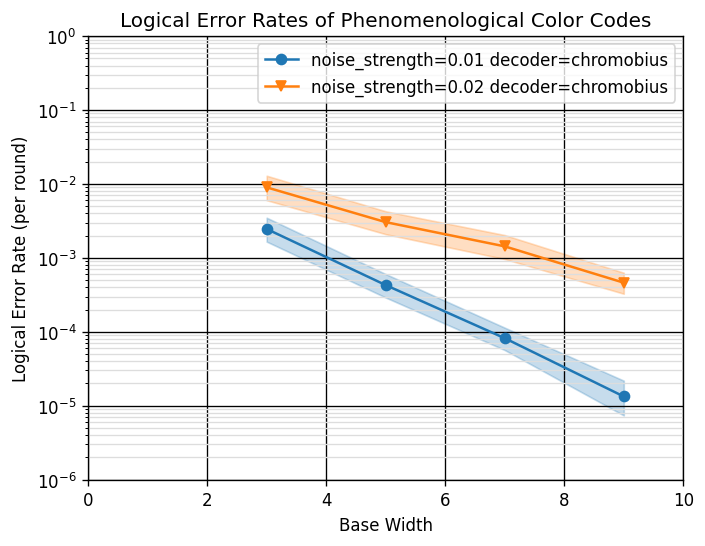

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=stats,
    x_func=lambda stat: stat.json_metadata['d'],
    group_func=lambda stat: f"""noise_strength={stat.json_metadata['p']} decoder={stat.decoder}""",
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(1e-6, 1e-0)
ax.set_xlim(0, 10)
ax.semilogy()
ax.set_title("Logical Error Rates of Phenomenological Color Codes")
ax.set_xlabel("Base Width")
ax.set_ylabel("Logical Error Rate (per round)")
ax.grid(which='major', color='#000000')
ax.grid(which='minor', color='#DDDDDD')
ax.legend()
fig.set_dpi(120)  # Show it bigger

and that's it!

# Conclusion

In this getting started notebook you learned:
- how to make a phenomenological color code circuit that chromobius could understand
- how to decode shots of that circuit using chromobius
- how to use sinter to collect statistics about how often chromobius was succeeding
- how to plot error rate statistics